In [50]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
%matplotlib inline

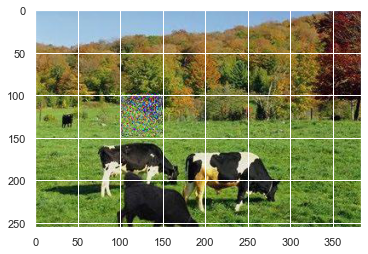

In [51]:
img = plt.imread("./9.jpg")
plt.imshow(img)

In [57]:
reconstruction = np.load("./1_reconstruction.npy")
features = np.load("./1_features.npy")

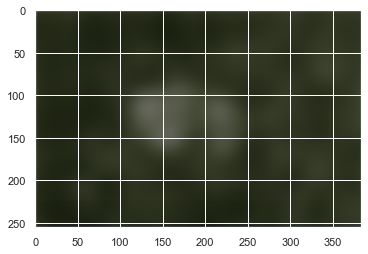

In [60]:
plt.imshow(reconstruction)

<AxesSubplot:>

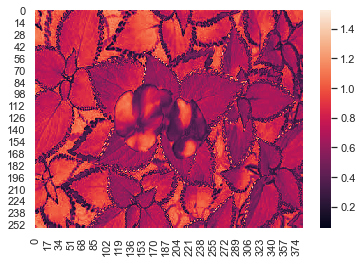

In [56]:
error = np.load("./1_error.npy")
sns.heatmap(error)